In [2]:
#region imports
from IPython import get_ipython



# noinspection PyBroadException
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass

# noinspection PyUnresolvedReferences
import datetime as dt
# noinspection PyUnresolvedReferences
import glob
# noinspection PyUnresolvedReferences
import os
# noinspection PyUnresolvedReferences
import pprint
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import cartopy as crt
# noinspection PyUnresolvedReferences
import matplotlib as mpl
# noinspection PyUnresolvedReferences
import matplotlib.colors
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import xarray as xr
# noinspection PyUnresolvedReferences
import bnn_tools.bnn_array
import bnn_tools.basic_funs as bu
import mod.funs as fu

plt.style.use('default')
xr.set_options(
    display_expand_data = False,
    display_expand_data_vars = True,
    display_max_rows = 10,
    display_style = 'html',
    display_width = 80,
    display_expand_attrs = False
);
#endregion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dn = (
    xr.open_dataset('../data/d1/npsd-hy-nais.nc')
    .expand_dims({'id':['nais']})
)

ds = (
    xr.open_dataset('../data/d1/npsd-hy-dmps.nc')
    .expand_dims({'id':['dmps']})
)

N = '$N_{2.5-5\mathrm{nm}}$'
d5 = (
    xr.open_dataset('../data/d1/ds_5.nc')
    .rename({'N':N})
)

In [4]:
d1 = (
    xr.concat([dn,ds],dim='id')
    .drop('lDp')
)
d1

<xarray.Dataset>
Dimensions:  (Dp: 52, time: 175293, id: 2)
Coordinates:
  * Dp       (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 8.913e-07 1e-06
  * time     (time) datetime64[ns] 2018-01-01 ... 2022-12-31T23:00:00
  * id       (id) object 'nais' 'dmps'
Data variables:
    dndlDp   (id, time, Dp) float64 1.167e+03 914.7 741.2 ... 5.461 7.81 3.218

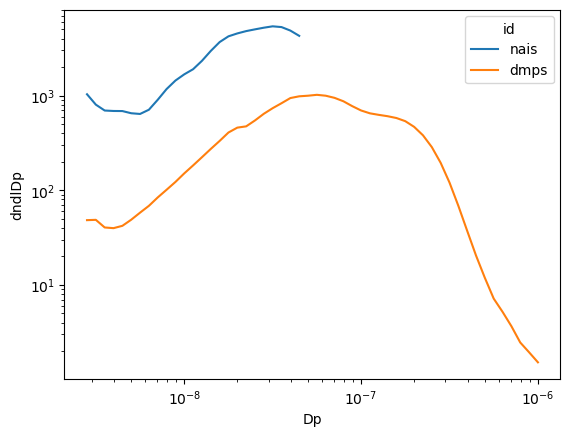

In [5]:
(
    d1
    .median('time')
    ['dndlDp']
    .plot(
        hue='id',
        yscale='log',
        xscale='log'
    )
)

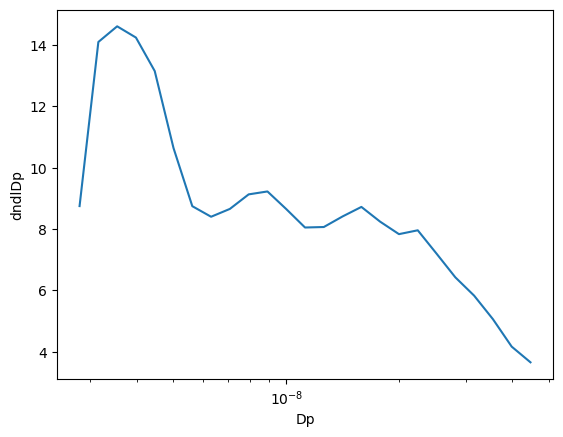

In [6]:
(
    d1
    .pipe(lambda d:(
              d.loc[{'id':'nais'}] /
              d.loc[{'id':'dmps'}]
            )
          )
    .median('time')
    ['dndlDp']
    .plot(
        hue='id',
        # yscale='log',
        xscale='log'
    )
)

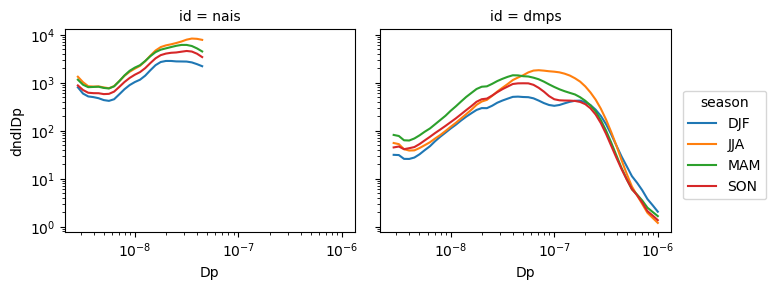

In [7]:
(
    d1
    .assign({'season':lambda d:d['time'].dt.season})
    .groupby('season')
    .median('time')
    ['dndlDp']
    .plot(
        hue='season',
        col='id',
        yscale='log',
        xscale='log'
    )
)

In [8]:
d1['Dp'].min()

<xarray.DataArray 'Dp' ()>
2.818e-09

In [9]:
def get_nais_dmps(d):
    d1 = d[['dndlDp']].loc[{'id':'nais','Dp':slice(0,2.e-8)}]
    d2 = d[['dndlDp']].loc[{'id':'dmps','Dp':slice(2.e-8+.00001e-8,1)}]*2
    dc = xr.concat([d1, d2], dim='Dp')
    dc['id'] = 'nd'

    dcc = xr.concat([d,dc],dim='id')
    return dcc

In [10]:

d2 = (
    d1
    .pipe(get_nais_dmps)
    .assign({
                N:lambda d:bu.get_exact_N(d.loc[{'id': 'nais'}]['dndlDp'], 2.82e-9, 5e-9)})
    .assign({'lN':lambda d:np.log10(d[N])})
)

d2

/Users/aliaga/py-packs/xarray_exc/xarray/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/aliaga/py-packs/xarray_exc/xarray/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:                 (Dp: 52, time: 175293, id: 3, Dp_interval: 1)
Coordinates:
  * Dp                      (Dp) float64 2.818e-09 3.162e-09 ... 8.913e-07 1e-06
  * time                    (time) datetime64[ns] 2018-01-01 ... 2022-12-31T2...
  * id                      (id) object 'nais' 'dmps' 'nd'
  * Dp_interval             (Dp_interval) object (2.82e-09, 5e-09]
Data variables:
    dndlDp                  (id, time, Dp) float64 1.167e+03 914.7 ... 6.437
    $N_{2.5-5\mathrm{nm}}$  (Dp_interval, time) float64 155.1 238.6 ... nan nan
    lN                      (Dp_interval, time) float64 2.191 2.378 ... nan nan

0

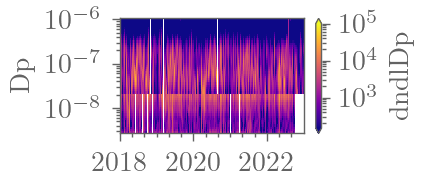

In [11]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot

w = 2.2
f, ax = plt.subplots(figsize=(w,w/1.6-.5))
f:plt.Figure
ax: plt.Axes
ax.set_box_aspect(1/1.6)
(
    d2
    ['dndlDp']
    .loc[{'id':'nd'}]
    .plot(
        y='Dp',
        yscale='log',
        norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e5),
        cmap = 'plasma',
        # col='d',
        # col_wrap=5,
        # size=1.4,
        # aspect = 1.6,
        rasterized = True,
        ax=ax,
    )

)
bu.format_ticks2(ax,2,10)
ax.set_title('')

ax.set_xlabel('')

import uscit
uscit.set_margin(f,.6,.4,.2,.1)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f010.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')
#endregion temp open fig


0

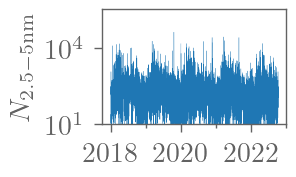

In [53]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot

w = 2.2
f, ax = plt.subplots(figsize=(w,w/1.6-.5))
f:plt.Figure
ax: plt.Axes
ax.set_box_aspect(1/1.6)
(
    d2
    [N]

    .plot(
        # y='Dp',
        yscale='log',
        # norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e5),
        # cmap = 'plasma',
        # col='d',
        # col_wrap=5,
        # size=1.4,
        # aspect = 1.6,
        # rasterized = True,
        ax=ax,
        ylim=(1e1,None),
        lw=.1,
        rasterized=True,
    )

)
bu.format_ticks2(ax,2,10)
ax.set_title('')

ax.set_xlabel('')

import uscit
uscit.set_margin(f,.6,.4,.2,.1)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f020.pdf';plt.gcf().savefig(_p_,transparent=True,dpi=600);
os.system(f'open {_p_}')
#endregion temp open fig


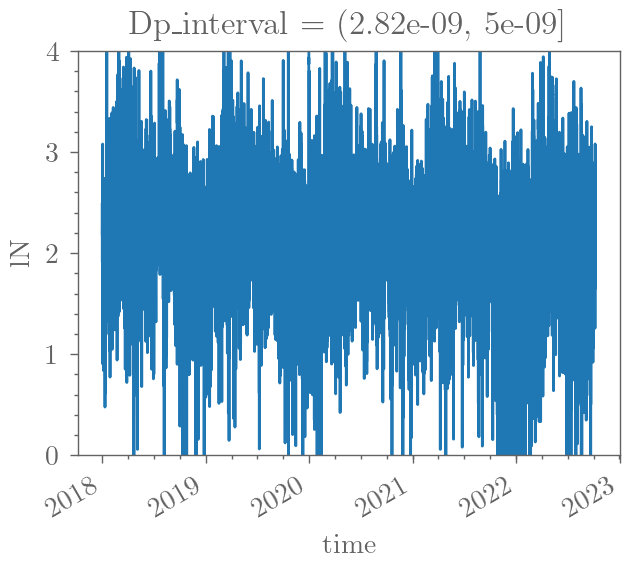

In [13]:
(
    d2
    ['lN']
    .plot(ylim=(0,4))
)

In [14]:
(
    d2
    .pipe(fu.unstack_day)

)

<xarray.Dataset>
Dimensions:                 (day: 1826, hour: 96, Dp: 52, id: 3, Dp_interval: 1)
Coordinates:
  * day                     (day) datetime64[ns] 2018-01-01 ... 2022-12-31
  * hour                    (hour) float64 0.0 0.25 0.5 ... 23.25 23.5 23.75
  * Dp                      (Dp) float64 2.818e-09 3.162e-09 ... 8.913e-07 1e-06
  * id                      (id) object 'nais' 'dmps' 'nd'
  * Dp_interval             (Dp_interval) object (2.82e-09, 5e-09]
    t                       (day, hour) datetime64[ns] 2018-01-01 ... NaT
Data variables:
    dndlDp                  (id, Dp, day, hour) float64 1.167e+03 ... nan
    $N_{2.5-5\mathrm{nm}}$  (Dp_interval, day, hour) float64 155.1 238.6 ... nan
    lN                      (Dp_interval, day, hour) float64 2.191 2.378 ... nan

0

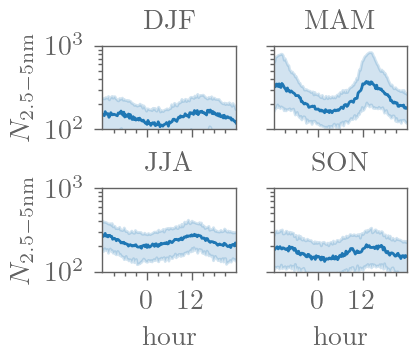

In [15]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot


res = (
    d5
    .assign_coords({'s':lambda d:d['day'].dt.season})
    [N]
    .to_dataframe()
    .pipe(
        lambda d:
        sns.relplot(
            data = d,
            x = 'hour',
            y=N,
            kind = 'line',
            col = 's',
            col_wrap=2,
            estimator='median',
            errorbar=('pi', 50),
            height = 1,
            aspect = 1.6,
            facet_kws=dict(despine= False,sharey=False,margin_titles=True),


        )
    )
)

res.set_titles('{col_name}')
for ax in res.axes.flat:
    ax.set_xticks(np.arange(-24,49,12))
    ax.set_xlim(-11.99,23.99)
    ax.set_yscale('log')
    ax.set_yticks([1e2,1e3])
    yy = ax.get_yticklabels(minor=True)
    y_ = ax.get_yticks(minor=True)
    ax.set_yticks(y_,minor=True)
    ax.set_yticklabels(['']*len(yy),minor=True)
    ax.set_ylim(1e2,1e3)
    ax.set_box_aspect(1/1.6)

for ax in res.axes[[1,3]]:
    ax.set_yticklabels(['',''])
    ax.set_ylabel(None)

f:plt.Figure = plt.gcf()
f.subplots_adjust(wspace=.1,hspace=.7)
f.set_size_inches(2.2,2)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f030.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')
#endregion temp open fig


In [16]:
ax.get_xticklabels(minor=True)

[Text(-9.0, 0, ''),
 Text(-6.0, 0, ''),
 Text(-3.0, 0, ''),
 Text(3.0, 0, ''),
 Text(6.0, 0, ''),
 Text(9.0, 0, ''),
 Text(15.0, 0, ''),
 Text(18.0, 0, ''),
 Text(21.0, 0, '')]

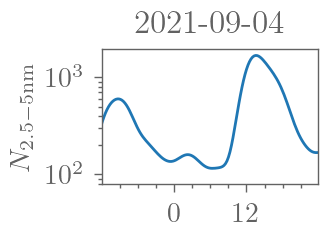

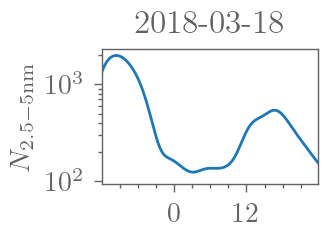

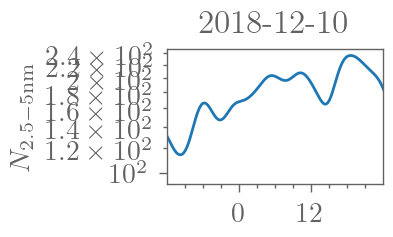

In [24]:
dd = ['2021-09-04','2018-03-18','2018-12-10']
for d_ in dd:
    w = 2.2
    f, ax = plt.subplots(figsize=(w,w/1.6-.5))
    f:plt.Figure
    ax: plt.Axes
    ax.set_box_aspect(1/1.6)

    (
        d5
        .loc[{'day': d_}]
        [N]
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .rolling({'hour':5},center=True).mean()
        .plot(
            # y='Dp',
            yscale='log',
            # norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e5),
            # cmap = 'plasma',
            # col='day',
            # col_wrap=5,
            # size=1.4,
            # aspect = 1.6,
            # rasterized = True,
            # ax=ax,
            # ylim=(1e1,None),
            # lw=.1
            ax =ax
        )
    )

    # bu.format_ticks2(ax,2,10)
    ax.set_title(d_)

    ax.set_xlabel('')

    ax.set_xticks(np.arange(-24,49,12))
    ax.set_xlim(-11.99,23.99)

    import uscit

    h_ = f.get_figheight()
    f.set_figheight(h_+.3)
    uscit.set_margin(f,.6,.4,.2,.1+.2)
    # uscit.set_fig_rule(f)
    #region temp open fig
    _p_ = f'f020{d_}.pdf';plt.gcf().savefig(_p_,transparent=True);
    os.system(f'open {_p_}')
    #endregion temp open fig

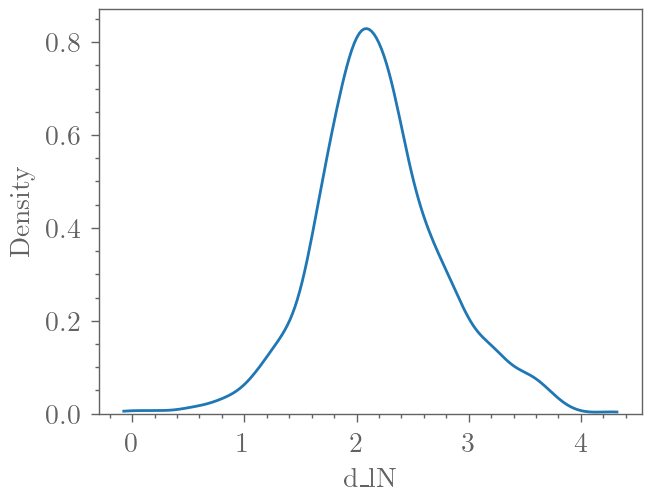

In [25]:
sns.kdeplot(
    data = d5['d_lN'].to_series(),
    bw_adjust=.98,
    clip=(d5['d_lN'].to_series().min(),d5['d_lN'].to_series().max())
    # log_scale = True
)
ax:plt.Axes = plt.gca()
# ax.set_yscale('symlog',linthresh=.05)

0

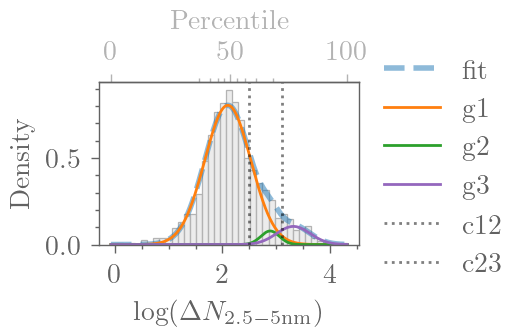

In [26]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot



# amplitude a, center c, and std s for gaussian 1
# first value is the best guess, second and third values are the lower and upper limit
# a1, a1m, a1M = (.1, 0, 3)
# c1, c1m, c1M = (2, 1.5, 2.5)
# s1, s1m, s1M = (.1, 0, 1)
#
# # amplitude a, center c, and std s for gaussian 3
# a2, a2m, a2M = (.1, 0, 3)
# c2, c2m, c2M = (2.6, 2.5, 3)
# s2, s2m, s2M = (.1, 0, .2)
#
# # amplitude a, center c, and std s for gaussian 3
# a3, a3m, a3M = (.1, 0, 3)
# c3, c3m, c3M = (3.1, 3, 4)
# s3, s3m, s3M = (.1, 0, .4)


a1, a1m, a1M = (.1, 0, 3)
c1, c1m, c1M = (2, 1.5, 2.5)
s1, s1m, s1M = (.1, 0, 1)

# amplitude a, center c, and std s for gaussian 3
a2, a2m, a2M = (.1, 0, 3)
c2, c2m, c2M = (2.6, 2.5, 3)
s2, s2m, s2M = (.1, 0, .2)

# amplitude a, center c, and std s for gaussian 3
a3, a3m, a3M = (.1, 0, 3)
c3, c3m, c3M = (3.1, 3, 4)
s3, s3m, s3M = (.1, 0, .4)

A = (a1, c1, s1, a2, c2, s2, a3, c3, s3,)
B = (a1m, c1m, s1m, a2m, c2m, s2m, a3m, c3m, s3m,)
C = (a1M, c1M, s1M, a2M, c2M, s2M, a3M, c3M, s3M,)



logn = d5['d_lN'].to_series().dropna()
mi, ma = logn.describe().T[['min', 'max']]
m12, m23, R = fu.fit_gaussians(logn, mi, ma, A, B, C, bw=.25)
R




ax:plt.Axes = plt.gca()

sns.histplot(
    logn,
    stat='density',
    ax=ax,
    color = '.9',
    edgecolor = '.7'
)


qq = logn.quantile(np.arange(0,1.01,.5))
# qq = logn.quantile([0,.1,.9,1])
qq_ = logn.quantile(np.arange(0,1.01,.1))
aa = ax.secondary_xaxis('top')
aa.set_xticks(qq)
aa.set_xticks(qq_,minor=True)
aa.set_xticklabels((qq.index*100).astype(int))

aa.set_xlabel('Percentile')
aa.xaxis.label.set_color('.7')
aa.tick_params(colors='.7', which='both')


ax.set_ylabel('Density')
ax.set_xlabel('$\log(\Delta N_{2.5-5\mathrm{nm}})$')
ax.set_box_aspect(1/1.6)
f:plt.Figure = plt.gcf()
f.set_size_inches(2.8,1.5+.3)


uscit.set_margin(f,x2=1,y1=.4,x1=.5,y2=.3)
sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1.3))

# uscit.set_fig_rule(f)

#region temp open fig
_p_ = 'f040.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')
#endregion temp open fig



In [453]:
aa.xaxis.set(color='.9')

AttributeError: XAxis.set() got an unexpected keyword argument 'color'

In [ ]:
xr.DataArray.plot()

0

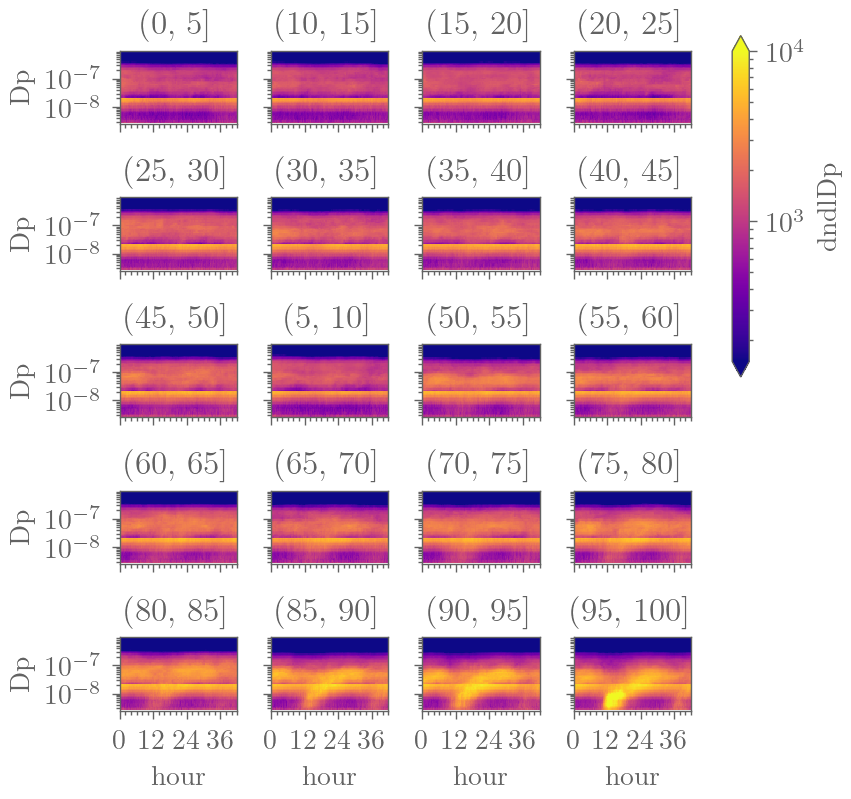

In [54]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot

res = (
    d5
    [['dndlDp','qCut']]
    .where(lambda d:d['qCut'] != 'nan',drop=True)
    .groupby('qCut')
    .median()
    .loc[{'id':'nd'}]
    ['dndlDp']
    .plot(
        y='Dp',
        yscale='log',
        norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e4),
        cmap = 'plasma',
        col='qCut',
        col_wrap=4,
        size=1.2,
        aspect = 1.6,
        cbar_kwargs = dict(fraction=.05,shrink=.5,panchor = (1,1),anchor=(-3,1)),
        rasterized=True
    )

)

res.set_titles('{value}')

for ax in res.axs.flat:
    ax:plt.Axes
    ax.set_box_aspect(1/1.6)
    yy = 36 + 6
    ax.set_xlim(0,yy)
    ax.set_ylim(2.5e-9,.99e-6)
    ti = np.arange(0, yy + 1, 12)
    ax.set_xticks(ti)
    ax.set_xticks(np.arange(0, yy+1, 2), minor=True)
    # ax.set_xticklabels(np.mod(ti,24))
    t = ax.get_title()
    ax.set_title(t.replace('.0',''))
f:plt.Figure = plt.gcf()
f.set_size_inches(4.3,4)

f.subplots_adjust(hspace=1,wspace=.2)
uscit.set_margin(f,x2=.8,x1=.6,y2=.3,y1=.4)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f050.pdf';plt.gcf().savefig(_p_,transparent=True,dpi=600);
os.system(f'open {_p_}')
#endregion temp open fig


0

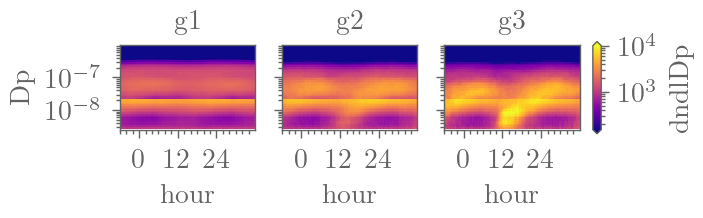

In [49]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot

res = (
    d5
    [['dndlDp','g']]
    .where(lambda d:d['g'] != '',drop=True)
    .groupby('g')
    .median()
    .loc[{'id':'nd'}]
    ['dndlDp']
    .plot(
        y='Dp',
        yscale='log',
        norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e4),
        cmap = 'plasma',
        col='g',
        size=1.5,
        aspect = 1.6,
        cbar_kwargs = dict(aspect = 11),
        rasterized=True
    )

)

res.set_titles('{value}')


for ax in res.axs.flat:
    ax:plt.Axes
    ax.set_box_aspect(1/1.6)
    yy = 36-.01
    y_ = -6
    ax.set_ylim(2.5e-9,.99e-6)
    ti = np.arange(0, yy + 1, 12)
    ax.set_xticks(ti)
    ax.set_xticks(np.arange(-6, yy+1, 2), minor=True)
    # ax.set_xticklabels(np.mod(ti,24))
    ax.set_xlim(-6,yy)

f:plt.Figure = plt.gcf()
f.set_size_inches(3.5,1.1)
uscit.set_margin(f,y1=.4,x2=.6,x1=.6)
f.subplots_adjust(wspace=.2)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f60.pdf';plt.gcf().savefig(_p_,transparent=True,dpi=600);
os.system(f'open {_p_}')
#endregion temp open fig


In [55]:
vc = d5['g'].where(lambda d:d['g'] != '',drop=True).to_series().value_counts().reset_index().reset_index()

In [356]:
vc

,level_0,index,g
0,0,g1,1175
1,1,g2,291
2,2,g3,121


In [364]:
r['g']

TypeError: tuple indices must be integers or slices, not str

0

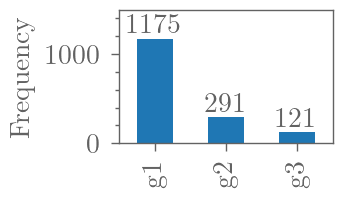

In [57]:
d5['g'].where(lambda d:d['g'] != '',drop=True).to_series().value_counts().plot.bar()
f:plt.Figure = plt.gcf()
f.set_size_inches(2.5,1.1)
ax:plt.Axes = plt.gca()
for k,r in vc.iterrows():
    ax.text(r['level_0'],r['g'],r['g'],ha='center',va='bottom')
ax.set_ylim(0,1499)
ax.set_box_aspect(1/1.6)
ax.set_ylabel('Frequency')
uscit.set_margin(f,x1=.6,y1=.3)
ax.set_xticks([],minor=True)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f070.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')
#endregion temp open fig


In [340]:
vc = d5['g'].to_series().value_counts()

In [341]:
vc

g1    1175
g2     291
       239
g3     121
Name: g, dtype: int64

In [339]:
vc/vc.sum() * 100

g1    74.039067
g2    18.336484
g3     7.624449
Name: g, dtype: float64

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_50795/1921653900.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,3000)


0

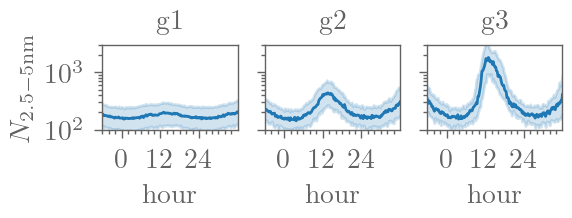

In [51]:
ser = (
    d5[N]
    .where(lambda d:d['g'] != '',drop=True)
    .to_dataframe()
)

res = sns.relplot(
    data = ser,
    x = 'hour',
    y=N,
    kind = 'line',
    col = 'g',
    estimator='median',
    errorbar=('pi', 50),
    height = 1,
    aspect = 1.6,
    facet_kws=dict(despine= False,sharey=True),


)

res.set_titles('{col_name}')



for ax in res.axes.flat:
    ax.set_xticks(np.arange(-24,49,12))
    ax.set_ylim(0,3000)
    ax.set_yscale('log')
    ax.set_ylim(1e2,3e3)
    ax.set_box_aspect(1/1.6)

    yy = 36-.01
    ax.set_xlim(-6,yy)
    # ax.set_ylim(2.5e-9,.99e-6)
    ti = np.arange(0, yy + 1, 12)
    ax.set_xticks(ti)
    ax.set_xticks(np.arange(-6, yy+1, 2), minor=True)
    ax.set_xlim(-6,yy)

f:plt.Figure = plt.gcf()
f.set_size_inches(3.5,1.5)
uscit.set_margin(f,y1=.4,x2=.6,x1=.6,y2=.2)
f.subplots_adjust(wspace=.2)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f080.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')


/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_50795/1437038947.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,3000)


0

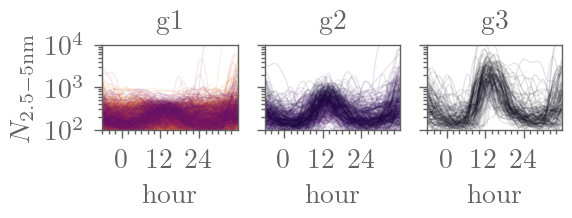

In [52]:
ser = (
    d5[N]
    .rolling({'hour':5},center=True).mean()
    .rolling({'hour':5},center=True).mean()
    .rolling({'hour':5},center=True).mean()
    .rolling({'hour':5},center=True).mean()
    .rolling({'hour':5},center=True).mean()
    .rolling({'hour':5},center=True).mean()
    .rolling({'hour':5},center=True).mean()

    .where(lambda d:d['g'] != '',drop=True)
    .to_dataframe()
)

res = sns.relplot(
    data = ser,
    x = 'hour',
    y=N,
    kind = 'line',
    col = 'g',
    estimator=None,
    units = 'day',
    errorbar=('pi', 50),
    height = 1,
    aspect = 2.5,
    alpha=.1,
    lw=.5,
    legend=False,
    hue = 'q',
    palette='inferno_r',
    facet_kws=dict(despine= False,sharey=True),
    rasterized=True,

)

res.set_titles('{col_name}')

for ax in res.axes.flat:
    ax.set_xticks(np.arange(-24,49,12))
    ax.set_ylim(0,3000)
    ax.set_yscale('log')
    ax.set_ylim(1e2,1e4)
    ax.set_box_aspect(1/1.6)
    yy = 36-.01

    # ax.set_ylim(2.5e-9,.99e-6)
    ti = np.arange(0, yy + 1, 12)
    ax.set_xticks(ti)
    ax.set_xticks(np.arange(-6, yy+1, 2), minor=True)

    ax.set_xlim(-6,yy)

f:plt.Figure = plt.gcf()
f.set_size_inches(3.5,1.5)
uscit.set_margin(f,y1=.4,x2=.6,x1=.6,y2=.2)
f.subplots_adjust(wspace=.2)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f090.pdf';plt.gcf().savefig(_p_,transparent=True,dpi=600);
os.system(f'open {_p_}')


In [ ]:
xr.DataArray

In [ ]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot
for g in ['g1','g2','g3']:
    res = (
        d5
        [['dndlDp','g']]
        .where(lambda d:d['g']==g,drop=True)
        .pipe(lambda d: d.loc[{'day':d['day'].to_series().sample(5*10).to_xarray()}])
        .loc[{'id':'nd'}]
        ['dndlDp']
        .plot(
            y='Dp',
            yscale='log',
            norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=10e4),
            cmap = 'plasma',
            col='day',
            col_wrap=5,
            size=1.2,
            aspect = 1.6,
            rasterized = True
        )

    )



    for ax in res.axs.flat:
        ax:plt.Axes
        ax.set_box_aspect(1/1.6)
        yy = 36 + 6
        ax.set_xlim(0,yy)
        ax.set_ylim(1e-9,1e-6)
        ti = np.arange(0, yy + 1, 6)
        ax.set_xticks(ti)
        ax.set_xticks(np.arange(0, yy+1, 2), minor=True)
        ax.set_xticklabels(np.mod(ti,24))

In [29]:
se = (
    d5
    ['d_lN']
    .squeeze()
    .to_series()
)

In [ ]:
m12

0

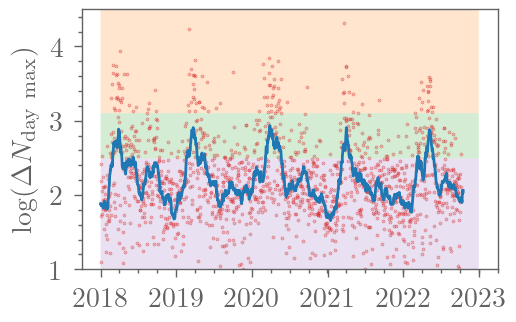

In [60]:
f, ax = plt.subplots()
f:plt.Figure
ax: plt.Axes

ax.fill_between(se.index,0,m12,alpha=.2,color = 'C4',ec='none')
ax.fill_between(se.index,m12,m23,alpha=.2,color = 'C2',ec='none')
ax.fill_between(se.index,m23,5,alpha=.2,color = 'C1',ec='none')
ax.scatter(se.index,se,s=.1,alpha=.5,c='C3', rasterized=True)
ax.plot(se.index,se.rolling('30D',center=True,min_periods=5).mean())
ax.set_ylim(1,4.5)
ax.set_ylabel('log($\Delta N_{\mathrm{day\ max}}$)')
ax.set_box_aspect(1/1.6)
f:plt.Figure = plt.gcf()
f.set_size_inches(3,2)
uscit.set_margin(f,y1=.4,x2=.1,x1=.6,y2=.3)
f.subplots_adjust(wspace=.2)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f100.pdf';plt.gcf().savefig(_p_,transparent=True, dpi=600);
os.system(f'open {_p_}')